In [34]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
plt.rc('font',family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings(action='ignore')

df_raw=pd.read_csv('../data/raw_data/train.csv')
df=df_raw.copy()

sample_submission_raw=pd.read_csv('../data/raw_data/sample_submission.csv')
sample_submission=sample_submission_raw.copy()

In [35]:
df['일시']=pd.to_datetime(df['일시'],format="%Y%m%d")
df.set_index('일시',inplace=True)

df['일'] = df.index.day
df['월'] = df.index.month
df['년'] = df.index.year
df['요일']=df.index.day_of_week
df['주']=df.index.week

df['주말평일'] = df['요일'].apply(lambda x: '평일' if x < 5 else '주말')

# --

sample_submission['일시']=pd.to_datetime(sample_submission['일시'],format="%Y%m%d")
sample_submission.set_index('일시',inplace=True)

sample_submission['일'] = sample_submission.index.day
sample_submission['월'] = sample_submission.index.month
sample_submission['년'] = sample_submission.index.year
sample_submission['요일']=sample_submission.index.day_of_week
sample_submission['주']=sample_submission.index.week

sample_submission['주말평일'] = sample_submission['요일'].apply(lambda x: '평일' if x < 5 else '주말')

sample_submission['주']=sample_submission['주'].apply(lambda x: 1 if x==52 else x)

In [36]:
from pytimekr import pytimekr
def get_holiday(_year):
    holidays=[]
    for holiday in pytimekr.holidays(year=_year):
        if pytimekr.red_days(holiday) != None:
            ans = [i.strftime("%Y-%m-%d") for i in pytimekr.red_days(holiday)]
            holidays.extend(ans)
        else:
            ans=holiday.strftime("%Y-%m-%d")
            holidays.append(ans)
    return list(set(holidays))

In [37]:
df.loc[get_holiday(2018),'주말평일'] = '주말'
df.loc[get_holiday(2019),'주말평일'] = '주말'
df.loc[get_holiday(2020),'주말평일'] = '주말'
df.loc[get_holiday(2021),'주말평일'] = '주말'
sample_submission.loc[sorted(get_holiday(2022))[:-1],'주말평일'] ='주말'

In [38]:
weekly_mean=df.groupby(['주','주말평일'])[df.columns[:4]].mean()
weekly_mean=weekly_mean.reset_index()

In [39]:
temp=pd.merge(sample_submission,weekly_mean,on=['주말평일','주'])

temp['date'] = temp['년'].apply(lambda x : str(x)) + temp['월'].apply(lambda x : '_'+str(x).zfill(2)) + temp['일'].apply(lambda x : '_'+str(x).zfill(2))
temp.index=pd.to_datetime(temp['date'],format='%Y_%m_%d')
temp.sort_index(inplace=True)

weekly_mean_ans=temp.copy()

In [40]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [41]:
my=weekly_mean_ans.iloc[:,10:-1]

In [42]:
for col in my.columns:
    my[col][10:] = smooth(my[col],10)[10:]

In [43]:
df_2018_raw = df[df.index.year == 2018]
df_2019_raw = df[df.index.year == 2019]
df_2020_raw = df[df.index.year == 2020]
df_2021_raw = df[df.index.year == 2021]

In [44]:
df_2018_raw =df_2018_raw.groupby(['주','주말평일'])[df_2018_raw.columns[:4]].mean()
df_2019_raw =df_2019_raw.groupby(['주','주말평일'])[df_2019_raw.columns[:4]].mean()
df_2020_raw =df_2020_raw.groupby(['주','주말평일'])[df_2020_raw.columns[:4]].mean()
df_2021_raw =df_2021_raw.groupby(['주','주말평일'])[df_2021_raw.columns[:4]].mean()

In [45]:
df_2018_raw.columns = [str(i)+'2018' for i in df_2018_raw.columns]
df_2019_raw.columns = [str(i)+'2019' for i in df_2019_raw.columns]
df_2020_raw.columns = [str(i)+'2020' for i in df_2020_raw.columns]
df_2021_raw.columns = [str(i)+'2021' for i in df_2021_raw.columns]

In [46]:
df_2018_raw.reset_index()

,주,주말평일,광진구2018,동대문구2018,성동구2018,중랑구2018
0,1,주말,0.602667,0.456000,0.627333,0.209333
1,1,평일,0.934400,0.632400,1.020000,0.350400
2,2,주말,0.494000,0.355000,0.504000,0.179000
3,2,평일,0.585600,0.417200,0.702800,0.168400
4,3,주말,0.717000,0.467000,0.726000,0.272000
...,...,...,...,...,...,...
99,50,평일,2.092800,1.301600,1.776400,0.847200
100,51,주말,1.779000,1.201000,1.357000,0.846000
101,51,평일,2.523600,1.599200,2.281200,0.986800
102,52,주말,1.152000,0.693333,0.878000,0.543333


In [47]:
temp_1=pd.merge(df_2018_raw.reset_index(),df_2019_raw.reset_index(),on=['주','주말평일'])
temp_2=pd.merge(df_2020_raw.reset_index(),df_2021_raw.reset_index(),on=['주','주말평일'])

In [48]:
diff_df=pd.merge(temp_1,temp_2,on=['주','주말평일'])

In [49]:
df_diff_광진구=diff_df.loc[:,[i for i in diff_df.columns if i.startswith('광진구')] + ['주','주말평일']]
df_diff_동대문구=diff_df.loc[:,[i for i in diff_df.columns if i.startswith('동대문구')] + ['주','주말평일']]
df_diff_성동구=diff_df.loc[:,[i for i in diff_df.columns if i.startswith('성동구')] + ['주','주말평일']]
df_diff_중랑구=diff_df.loc[:,[i for i in diff_df.columns if i.startswith('중랑구')] + ['주','주말평일']]

In [50]:
df_diff_광진구['diff_mean_광진구']=df_diff_광진구.iloc[:,:4].diff(axis=1).fillna(0).mean(axis=1)
df_diff_동대문구['diff_mean_동대문구']=df_diff_동대문구.iloc[:,:4].diff(axis=1).fillna(0).mean(axis=1)
df_diff_성동구['diff_mean_성동구']=df_diff_성동구.iloc[:,:4].diff(axis=1).fillna(0).mean(axis=1)
df_diff_중랑구['diff_mean_중랑구']=df_diff_중랑구.iloc[:,:4].diff(axis=1).fillna(0).mean(axis=1)

In [51]:
my_diff=weekly_mean_ans.iloc[:,8:-1]

In [52]:
temp=my_diff.merge(df_diff_광진구,on=['주','주말평일'])

In [60]:
my_18 = my.copy()

In [61]:
my_18.iloc[:,0]=my_18.iloc[:,0]*2
my_18.iloc[:,1]=my_18.iloc[:,1]*2
my_18.iloc[:,2]=my_18.iloc[:,2]*2
my_18.iloc[:,3]=my_18.iloc[:,3]*2

In [56]:
my_18.mean()

광진구_y     12.186221
동대문구_y     8.263233
성동구_y     10.179011
중랑구_y      6.148303
dtype: float64

In [59]:
df[df['년']==2021].iloc[:,:4].mean()

광진구     8.165704
동대문구    6.660734
성동구     6.917874
중랑구     4.779370
dtype: float64

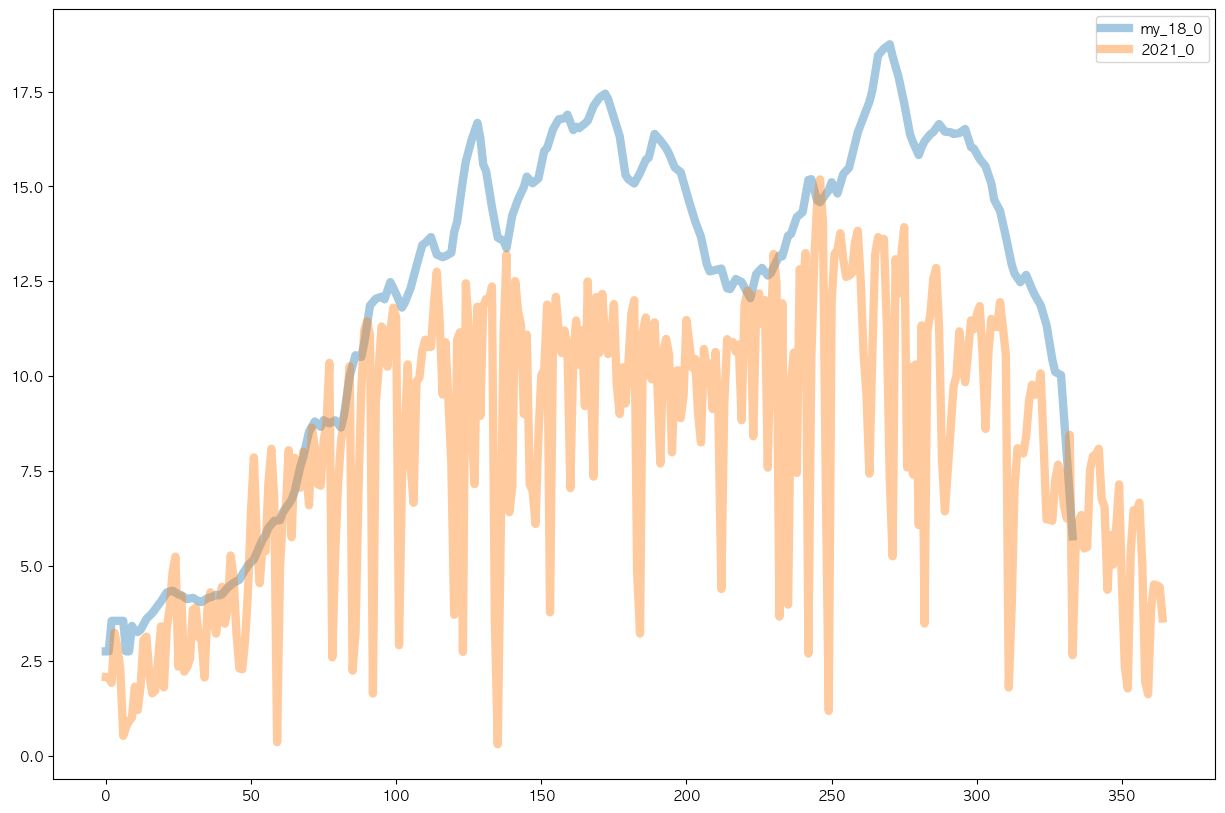

In [33]:
for i in [0]:
    my_18.reset_index(drop=True).iloc[:,i].plot(label = f'my_18_{i}',figsize=(15,10),alpha=0.4,lw=6)
    df[df['년']==2021].reset_index(drop=True).iloc[:,i].plot(label = f'2021_{i}',figsize=(15,10),alpha=0.4,lw=6)
plt.legend()
plt.show()

In [62]:
for col in my_18.columns:
    my_18[col][10:-10] = smooth(my_18[col],5)[10:-10]

In [63]:
sample_submission_raw.iloc[:,1:] = my_18.values

In [64]:
sample_submission_raw.to_csv('based_on_weekly_mean18.csv',index=False)